<a href="https://colab.research.google.com/github/inkatown/Computer-Vision/blob/main/FaceLandMarksdlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Copyright (c) 2015 Matthew Earl
 
 Permission is hereby granted, free of charge, to any person obtaining a copy
 of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
 to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 copies of the Software, and to permit persons to whom the Software is
 furnished to do so, subject to the following conditions:
 
     The above copyright notice and this permission notice shall be included
     in all copies or substantial portions of the Software.
 
     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
     OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
     MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN
     NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
     DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
     OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE
     USE OR OTHER DEALINGS IN THE SOFTWARE.

> Indented block



In [ ]:
import cv2
import dlib
import numpy
from google.colab.patches import cv2_imshow


PREDICTOR_PATH = "/content/shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)

    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im



In [ ]:
def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im
    
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         numpy.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

In [ ]:
im1, landmarks1 = read_im_and_landmarks('/content/huacoloc.jpg')
im2, landmarks2 = read_im_and_landmarks('/content/mariluz.jpeg')

M = transformation_from_points(landmarks1[ALIGN_POINTS],
                               landmarks2[ALIGN_POINTS])

mask = get_face_mask(im2, landmarks2)
warped_mask = warp_im(mask, M, im1.shape)
combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                          axis=0)

warped_im2 = warp_im(im2, M, im1.shape)
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

cv2.imwrite('output.jpg', output_im)

True

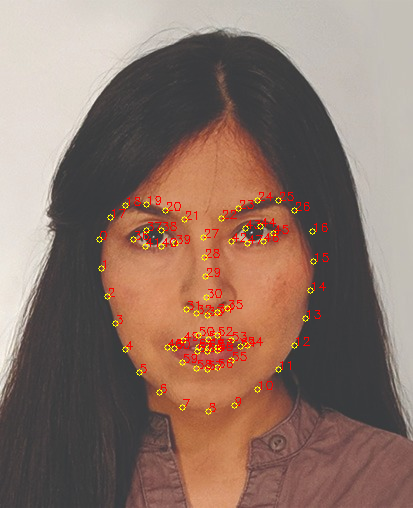

In [ ]:
image = cv2.imread('/content/mariluz.jpeg')
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)

cv2_imshow(image_with_landmarks)
cv2.imwrite('image_with_landmarks.jpg',image_with_landmarks)
cv2.waitKey(0)
cv2.destroyAllWindows()